In [2]:
import os, sys
os.environ['CUDA_VISIBLE_DEVICES'] = "2"
import torch
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib as plt
from PIL import Image
sys.path.append('../src')
from utils import *
from matplotlib.lines import Line2D
import matplotlib as mpl
import math
import matplotlib.image as mpimg
import scipy.stats as stats
from stochastic_search import StochasticSearch
import scipy as sp
from scipy.stats import pearsonr,binom,linregress
from ast import literal_eval
import json

/export/raid1/home/ojeda040/miniconda3/envs/SS_UC/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Used in CCN
# folder   = "SCS UC 10:250:5 0.6 Exp3 AE Fixed copy"
# log_path = "/export/raid1/home/kneel027/Second-Sight/logs/" + folder + "/statistics_df_60.csv"


# Second Sight
subject = 1
folder = "Final Run: SCS UC LD 6:100:4 Dual Guided clip_iter"
directory_path = "/export/raid1/home/ojeda040/Second-Sight/reconstructions/subject" + str(subject) + "/" + folder + "/statistics_df_897.csv"

# Brain Diffuser
# subject = 1
# folder = "Brain Diffuser regen"
# directory_path = "/export/raid1/home/ojeda040/Second-Sight/reconstructions/subject" + str(subject) + "/" + folder + "/statistics_df_897.csv"

# Tagaki
# subject = 1
# folder = "Tagaki"
# directory_path = "/export/raid1/home/ojeda040/Second-Sight/reconstructions/subject" + str(subject) + "/" + folder + "/statistics_df_897.csv"

df = pd.read_csv(directory_path)
df.tail(20)

#   0 --> Ground Truth
#   1 --> VDVAE Distribution        (Decoded Distribution)
#   2 --> Clip Distrubituon         (Decoded CLIP Only)
#   3 --> Clip Distrubituon + VDVAE (Decoded CLIP + VDVAE)
#   4 --> iter_0
#   5 --> iter_1
#   6 --> iter_2
#   7 --> iter_3
#   8 --> iter_4
#   9 --> iter_5
#  10 --> Search Reconstruction

# {"clip_distribution" : 1, "vdvae_distribution" : 2, "clip+vdvae_distribution" : 3, "iter_0" : 4, "iter_1" : 5 , "iter_2" : 6, "iter_3" : 7, "iter_4" : 8, "iter_5" : 9}


,Unnamed: 0,ID,Sample Count,Batch Number,Search Reconstruction,Sample Indicator,Strength,Brain Correlation V1,Brain Correlation V2,Brain Correlation V3,...,SSIM,Pixel Correlation,CLIP Cosine,CLIP Two-way,AlexNet 2,AlexNet 5,AlexNet 7,Inception V3,EffNet-B,SwAV
42139,42139,981,2.0,1.0,False,6,0.882500,0.669538,0.712021,0.771025,...,0.308128,0.367241,0.780912,"[0.6386961340904236, 0.6317774057388306, -0.46...","[0.0, 0.0, 0.0, 0.771309494972229, 0.200765728...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.7854865789413452, 0.06420563161373138, 0.78...","[0.05795231834053993, 0.2526743412017822, -0.0...","[0.0067038824781775475, 0.02396276406943798, 0..."
42140,42140,981,3.0,1.0,False,6,0.831111,0.805677,0.776708,0.826988,...,0.339739,0.388469,0.793185,"[0.4532039761543274, -0.04363769292831421, -0....","[5.574509143829346, 3.0794131755828857, 0.4556...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.4210095405578613, 0.0, 0.0, 0.0, ...","[1.0741695165634155, 0.1598660796880722, 0.539...","[-0.0400678850710392, -0.07213933765888214, -0...","[0.0, 0.06830593943595886, 0.0871308371424675,..."
42141,42141,981,4.0,1.0,False,6,0.746389,0.457911,0.395653,0.404343,...,0.327196,0.293617,0.789840,"[-0.10331062972545624, 1.0383516550064087, -0....","[0.842261016368866, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.000792384147644, 0.1710541695356369, 0.4660...","[-0.03751968964934349, 0.19582799077033997, 0....","[0.0, 0.01632794365286827, 0.02774162217974662..."
42142,42142,981,0.0,0.0,True,7,0.918611,0.697908,0.627256,0.649389,...,0.323188,0.152386,0.791468,"[0.053920093923807144, 0.5915051102638245, 0.0...","[0.8390697240829468, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.40410494804382324, 0.0,...","[1.7022836208343506, 0.19363433122634888, 0.80...","[-0.07659804075956345, 0.04226769134402275, 0....","[0.005699468776583672, 0.04775238037109375, 0...."
42143,42143,981,1.0,0.0,True,7,0.908889,0.795938,0.728966,0.762828,...,0.348332,0.223930,0.841304,"[-0.26963376998901367, 1.0972751379013062, 0.0...","[0.47083961963653564, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.112764596939087, 0.42206308245658875, 0.647...","[-0.09107118844985962, -0.0358755886554718, -0...","[0.0, 0.04942859709262848, 0.0691206231713295,..."
42144,42144,981,2.0,0.0,True,7,0.882500,0.702194,0.532446,0.643157,...,0.331679,0.225884,0.780912,"[0.046586718410253525, 0.8245627880096436, 0.3...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.2263171672821045, 0.4199122488498688, 1.035...","[-0.04887644946575165, -0.09060250967741013, -...","[0.002323213731870055, 0.023618079721927643, 0..."
42145,42145,981,3.0,0.0,True,7,0.831111,0.807018,0.780077,0.857208,...,0.339486,0.196789,0.793185,"[0.10666275024414062, 0.3657122552394867, 0.21...","[1.7544258832931519, 0.012986771762371063, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.5134924650192261, 0.0, 0.0, 0.0, ...","[0.8071625828742981, 0.14714528620243073, 0.52...","[0.25271812081336975, 0.03430330753326416, 0.0...","[0.0, 0.11469121277332306, 0.07974065095186234..."
42146,42146,981,4.0,0.0,True,7,0.746389,0.877722,0.816958,0.875093,...,0.337511,0.260631,0.789840,"[0.5099677443504333, 0.21648328006267548, -0.1...","[1.3257988691329956, 0.4457587003707886, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.6211174726486206, 0.4318537414073944, 0.879...","[0.26886263489723206, 0.012005778960883617, -0...","[0.0, 0.073023222386837, 0.12262899428606033, ..."
42147,42147,981,0.0,0.0,False,8,0.918611

In [33]:
def column_string_to_list(df):
    
    df_new = df
    
    for index, row in tqdm(df.iterrows(), "creating lists"):
        
        df_new.at[index, 'CLIP Two-way']    = json.loads(row['CLIP Two-way'])
        df_new.at[index, 'AlexNet 2']       = json.loads(row['AlexNet 2'])
        df_new.at[index, 'AlexNet 5']       = json.loads(row['AlexNet 5'])
        df_new.at[index, 'AlexNet 7']       = json.loads(row['AlexNet 7'])
        df_new.at[index, 'Inception V3']    = json.loads(row['Inception V3'])
        df_new.at[index, 'EffNet-B']        = json.loads(row['EffNet-B'])
        df_new.at[index, 'SwAV']            = json.loads(row['SwAV'])
        
    return df_new

new_df = column_string_to_list(df)

creating lists: 5382it [03:11, 28.10it/s]


In [34]:
['ID', 'Sample Count', 'Batch Number', 'Search Reconstruction', 'Sample Indicator', 'Strength', 'Brain Correlation V1', 'Brain Correlation V2', 
'Brain Correlation V3', 'Brain Correlation V4', 'Brain Correlation Early Visual', 'Brain Correlation Higher Visual', 'Brain Correlation NSD General',
'SSIM', 'Pixel Correlation', 'CLIP Cosine', 'CLIP Two-way', 'AlexNet 2', 'AlexNet 5', 'AlexNet 7', 'Inception V3', 'EffNet-B', 'SwAV']

# Input: Dataframe containing the samples one type of image
def create_cnn_numpy_array(df):
    cnn_dict = {}
    df = df.reset_index()
    
    alexnet_2       = []
    alexnet_5       = []
    alexnet_7       = []
    clip_two_way    = []
    inception_v3    = []
    effnet_b        = []
    swav            = []
    
    for index, row in df.iterrows():
        
        alexnet_2.append(row['AlexNet 2'])
        alexnet_5.append(np.array(row['AlexNet 5']))
        alexnet_7.append(np.array(row['AlexNet 7']))
        clip_two_way.append(np.array(row['CLIP Two-way']))
        inception_v3.append(np.array(row['Inception V3']))
        effnet_b.append(np.array(row['EffNet-B']))
        swav.append(np.array(row['SwAV']))
    
    cnn_dict['AlexNet 2']      = np.concatenate([alexnet_2])
    cnn_dict['AlexNet 5']      = np.concatenate([alexnet_5])
    cnn_dict['AlexNet 7']      = np.concatenate([alexnet_7])
    cnn_dict['CLIP Two-way']   = np.concatenate([clip_two_way])
    cnn_dict['Inception V3']   = np.concatenate([inception_v3])
    cnn_dict['EffNet-B']       = np.concatenate([effnet_b])
    cnn_dict['SwAV']           = np.concatenate([swav])
    
    return cnn_dict

def pairwise_corr_all(ground_truth, predictions):
    r = np.corrcoef(ground_truth, predictions)#cosine_similarity(ground_truth, predictions)#
    r = r[:len(ground_truth), len(ground_truth):]  # rows: groundtruth, columns: predicitons
    #print(r.shape)
    # congruent pairs are on diagonal
    congruents = np.diag(r)
    #print(congruents)
    
    # for each column (predicition) we should count the number of rows (groundtruth) that the value is lower than the congruent (e.g. success).
    success = r < congruents
    success_cnt = np.sum(success, 0)
    
    # note: diagonal of 'success' is always zero so we can discard it. That's why we divide by len-1
    perf = np.mean(success_cnt) / (len(ground_truth)-1)
    p = 1 - binom.cdf(perf*len(ground_truth)*(len(ground_truth)-1), len(ground_truth)*(len(ground_truth)-1), 0.5)
    
    return perf, p

def compute_cnn_metrics(cnn_metrics_ground_truth, cnn_metrics_reconstructions):
    
    distance_fn = sp.spatial.distance.correlation
    pairwise_corrs = []
    cnn_metrics = {}
    
    for net_name, predictions_np in cnn_metrics_reconstructions.items():
        
        gt_feat = cnn_metrics_ground_truth[net_name]
        
        eval_feat = predictions_np
        num_test = predictions_np.shape[0]
        
        # print(net_name)
        if net_name == 'EffNet-B' or net_name == 'SwAV':
            cnn_metrics[net_name] = np.array([distance_fn(gt_feat[i],eval_feat[i]) for i in range(num_test)]).mean()
            #print('distance: ',np.array([distance_fn(gt_feat[i],eval_feat[i]) for i in range(num_test)]).mean())
        else:
            cnn_metrics[net_name] = pairwise_corr_all(gt_feat[:num_test],eval_feat[:num_test])[0]
            #pairwise_corrs.append(pairwise_corr_all(gt_feat[:num_test],eval_feat[:num_test])[0])
            #print('pairwise corr: ',pairwise_corrs[-1])
            
    return cnn_metrics  

In [35]:
# Statistical Analysis Tagaki/ Brain Diffuser/ Mind diffuser

['ID', 'Regen Number', 'Sample Indicator', 'SSIM', 'Pixel Correlation', 'CLIP Cosine', 
'CLIP Two-way', 'AlexNet 2', 'AlexNet 5', 'AlexNet 7', 'Inception V3', 'EffNet-B', 'SwAV']

df_final_samples    = new_df.loc[(new_df['Sample Indicator'] == 1)]
df_ground_truth     = new_df.loc[(new_df['Sample Indicator'] == 0)]
df_final_samples_0  = df_final_samples.loc[(df_final_samples['Regen Number'] == 0)]
df_final_samples_1  = df_final_samples.loc[(df_final_samples['Regen Number'] == 1)]
df_final_samples_2  = df_final_samples.loc[(df_final_samples['Regen Number'] == 2)]
df_final_samples_3  = df_final_samples.loc[(df_final_samples['Regen Number'] == 3)]
df_final_samples_4  = df_final_samples.loc[(df_final_samples['Regen Number'] == 4)]

cnn_metrics_0 = compute_cnn_metrics(create_cnn_numpy_array(df_ground_truth), create_cnn_numpy_array(df_final_samples_0))
cnn_metrics_1 = compute_cnn_metrics(create_cnn_numpy_array(df_ground_truth), create_cnn_numpy_array(df_final_samples_1))
cnn_metrics_2 = compute_cnn_metrics(create_cnn_numpy_array(df_ground_truth), create_cnn_numpy_array(df_final_samples_2))
cnn_metrics_3 = compute_cnn_metrics(create_cnn_numpy_array(df_ground_truth), create_cnn_numpy_array(df_final_samples_3))
cnn_metrics_4 = compute_cnn_metrics(create_cnn_numpy_array(df_ground_truth), create_cnn_numpy_array(df_final_samples_4))

print("------------------------------------------------ SSIM -----------------------------------------------------------------")

print("SSIM: ", df_final_samples['SSIM'].mean())

print("Confidence Interval SSIM: ", ((df_final_samples['SSIM'].std() * 1.96) / math.sqrt(len(df_final_samples.index))))

print("------------------------------------------------ Pixel Correlation -----------------------------------------------------------------")

print("Pixel Correlation: ", df_final_samples['Pixel Correlation'].mean())

print("Confidence Interval Pixel Correlation: ", ((df_final_samples['Pixel Correlation'].std() * 1.96) / math.sqrt(len(df_final_samples.index))))

print("------------------------------------------------ CLIP Cosine -----------------------------------------------------------------")

print("CLIP Cosine: ", df_final_samples['CLIP Cosine'].mean())

print("Confidence Interval CLIP Cosine: ", ((df_final_samples['CLIP Cosine'].std() * 1.96) / math.sqrt(len(df_final_samples.index))))

print("------------------------------------------------ CLIP Two-way -----------------------------------------------------------------")

print("CLIP Two-way: ", ((cnn_metrics_0['CLIP Two-way'] + cnn_metrics_1['CLIP Two-way'] + cnn_metrics_2['CLIP Two-way'] + cnn_metrics_3['CLIP Two-way'] + cnn_metrics_4['CLIP Two-way']) / 5))

print("------------------------------------------------ AlexNet 2 -----------------------------------------------------------------")

print("AlexNet 2: ", ((cnn_metrics_0['AlexNet 2'] + cnn_metrics_1['AlexNet 2'] + cnn_metrics_2['AlexNet 2'] + cnn_metrics_3['AlexNet 2'] + cnn_metrics_4['AlexNet 2']) / 5))

print("------------------------------------------------ AlexNet 5 -----------------------------------------------------------------")

print("AlexNet 5: ", ((cnn_metrics_0['AlexNet 5'] + cnn_metrics_1['AlexNet 5'] + cnn_metrics_2['AlexNet 5'] + cnn_metrics_3['AlexNet 5'] + cnn_metrics_4['AlexNet 5']) / 5))

print("------------------------------------------------ AlexNet 7 -----------------------------------------------------------------")

print("AlexNet 7: ", ((cnn_metrics_0['AlexNet 7'] + cnn_metrics_1['AlexNet 7'] + cnn_metrics_2['AlexNet 7'] + cnn_metrics_3['AlexNet 7'] + cnn_metrics_4['AlexNet 7']) / 5))

print("------------------------------------------------ Inception V3 -----------------------------------------------------------------")

print("Inception V3: ", ((cnn_metrics_0['Inception V3'] + cnn_metrics_1['Inception V3'] + cnn_metrics_2['Inception V3'] + cnn_metrics_3['Inception V3'] + cnn_metrics_4['Inception V3']) / 5))

print("------------------------------------------------ EffNet-B -----------------------------------------------------------------")

print("EffNet-B: ", ((cnn_metrics_0['EffNet-B'] + cnn_metrics_1['EffNet-B'] + cnn_metrics_2['EffNet-B'] + cnn_metrics_3['EffNet-B'] + cnn_metrics_4['EffNet-B']) / 5))

print("------------------------------------------------ SwAV -----------------------------------------------------------------")

print("SwAV: ", ((cnn_metrics_0['SwAV'] + cnn_metrics_1['SwAV'] + cnn_metrics_2['SwAV'] + cnn_metrics_3['SwAV'] + cnn_metrics_4['SwAV']) / 5))

------------------------------------------------ SSIM -----------------------------------------------------------------
SSIM:  0.21663915994773691
Confidence Interval SSIM:  0.003940761752044845
------------------------------------------------ Pixel Correlation -----------------------------------------------------------------
Pixel Correlation:  0.2687914163270234
Confidence Interval Pixel Correlation:  0.005923417784763132
------------------------------------------------ CLIP Cosine -----------------------------------------------------------------
CLIP Cosine:  0.5658699700309253
Confidence Interval CLIP Cosine:  0.0023060791117731037
------------------------------------------------ CLIP Two-way -----------------------------------------------------------------
CLIP Two-way:  0.6441824932314062
------------------------------------------------ AlexNet 2 -----------------------------------------------------------------
AlexNet 2:  0.7506173853320591
--------------------------------------

In [33]:
# Statistical Analysis Second Sight

df_final_samples    = new_df.loc[(new_df['Search Reconstruction'] == True)]
df_ground_truth     = new_df.loc[(new_df['Sample Indicator'] == 0)]
df_final_samples_0  = df_final_samples.loc[(df_final_samples['Sample Count'] == 0)]
df_final_samples_1  = df_final_samples.loc[(df_final_samples['Sample Count'] == 1)]
df_final_samples_2  = df_final_samples.loc[(df_final_samples['Sample Count'] == 2)]
df_final_samples_3  = df_final_samples.loc[(df_final_samples['Sample Count'] == 3)]
df_final_samples_4  = df_final_samples.loc[(df_final_samples['Sample Count'] == 4)]

cnn_metrics_0 = compute_cnn_metrics(create_cnn_numpy_array(df_ground_truth), create_cnn_numpy_array(df_final_samples_0))
cnn_metrics_1 = compute_cnn_metrics(create_cnn_numpy_array(df_ground_truth), create_cnn_numpy_array(df_final_samples_1))
cnn_metrics_2 = compute_cnn_metrics(create_cnn_numpy_array(df_ground_truth), create_cnn_numpy_array(df_final_samples_2))
cnn_metrics_3 = compute_cnn_metrics(create_cnn_numpy_array(df_ground_truth), create_cnn_numpy_array(df_final_samples_3))
cnn_metrics_4 = compute_cnn_metrics(create_cnn_numpy_array(df_ground_truth), create_cnn_numpy_array(df_final_samples_4))

print("------------------------------------------------ SSIM -----------------------------------------------------------------")

print("SSIM: ", df_final_samples['SSIM'].mean())

print("Confidence Interval SSIM: ", ((df_final_samples['SSIM'].std() * 1.96) / math.sqrt(len(df_final_samples.index))))

print("------------------------------------------------ Pixel Correlation -----------------------------------------------------------------")

print("Pixel Correlation: ", df_final_samples['Pixel Correlation'].mean())

print("Confidence Interval Pixel Correlation: ", ((df_final_samples['Pixel Correlation'].std() * 1.96) / math.sqrt(len(df_final_samples.index))))

print("------------------------------------------------ CLIP Cosine -----------------------------------------------------------------")

print("CLIP Cosine: ", df_final_samples['CLIP Cosine'].mean())

print("Confidence Interval CLIP Cosine: ", ((df_final_samples['CLIP Cosine'].std() * 1.96) / math.sqrt(len(df_final_samples.index))))

print("------------------------------------------------ CLIP Two-way -----------------------------------------------------------------")

print("CLIP Two-way: ", ((cnn_metrics_0['CLIP Two-way'] + cnn_metrics_1['CLIP Two-way'] + cnn_metrics_2['CLIP Two-way'] + cnn_metrics_3['CLIP Two-way'] + cnn_metrics_4['CLIP Two-way']) / 5))

print("------------------------------------------------ AlexNet 2 -----------------------------------------------------------------")

print("AlexNet 2: ", ((cnn_metrics_0['AlexNet 2'] + cnn_metrics_1['AlexNet 2'] + cnn_metrics_2['AlexNet 2'] + cnn_metrics_3['AlexNet 2'] + cnn_metrics_4['AlexNet 2']) / 5))

print("------------------------------------------------ AlexNet 5 -----------------------------------------------------------------")

print("AlexNet 5: ", ((cnn_metrics_0['AlexNet 5'] + cnn_metrics_1['AlexNet 5'] + cnn_metrics_2['AlexNet 5'] + cnn_metrics_3['AlexNet 5'] + cnn_metrics_4['AlexNet 5']) / 5))

print("------------------------------------------------ AlexNet 7 -----------------------------------------------------------------")

print("AlexNet 7: ", ((cnn_metrics_0['AlexNet 7'] + cnn_metrics_1['AlexNet 7'] + cnn_metrics_2['AlexNet 7'] + cnn_metrics_3['AlexNet 7'] + cnn_metrics_4['AlexNet 7']) / 5))

print("------------------------------------------------ Inception V3 -----------------------------------------------------------------")

print("Inception V3: ", ((cnn_metrics_0['Inception V3'] + cnn_metrics_1['Inception V3'] + cnn_metrics_2['Inception V3'] + cnn_metrics_3['Inception V3'] + cnn_metrics_4['Inception V3']) / 5))

print("------------------------------------------------ EffNet-B -----------------------------------------------------------------")

print("EffNet-B: ", ((cnn_metrics_0['EffNet-B'] + cnn_metrics_1['EffNet-B'] + cnn_metrics_2['EffNet-B'] + cnn_metrics_3['EffNet-B'] + cnn_metrics_4['EffNet-B']) / 5))

print("------------------------------------------------ SwAV -----------------------------------------------------------------")

print("SwAV: ", ((cnn_metrics_0['SwAV'] + cnn_metrics_1['SwAV'] + cnn_metrics_2['SwAV'] + cnn_metrics_3['SwAV'] + cnn_metrics_4['SwAV']) / 5))

------------------------------------------------ SSIM -----------------------------------------------------------------
SSIM:  0.28805564771959863
Confidence Interval SSIM:  0.00453115871984924
------------------------------------------------ Pixel Correlation -----------------------------------------------------------------
Pixel Correlation:  0.18516724942251953
Confidence Interval Pixel Correlation:  0.005675563279077434
------------------------------------------------ CLIP Cosine -----------------------------------------------------------------
CLIP Cosine:  0.6642020871800892
Confidence Interval CLIP Cosine:  0.003460082949051444
------------------------------------------------ CLIP Two-way -----------------------------------------------------------------
CLIP Two-way:  0.8827530259595477
------------------------------------------------ AlexNet 2 -----------------------------------------------------------------
AlexNet 2:  0.9166385471412646
---------------------------------------

In [34]:
# print("------------------------------------------------ CLIP Two-way -----------------------------------------------------------------")

# print("CLIP Two-way: ", (cnn_metrics_0['CLIP Two-way']))

# print("------------------------------------------------ AlexNet 2 -----------------------------------------------------------------")

# print("AlexNet 2: ", ((cnn_metrics_0['AlexNet 2'])))

# print("------------------------------------------------ AlexNet 5 -----------------------------------------------------------------")

# print("AlexNet 5: ", ((cnn_metrics_0['AlexNet 5'])))

# print("------------------------------------------------ AlexNet 7 -----------------------------------------------------------------")

# print("AlexNet 7: ", ((cnn_metrics_0['AlexNet 7'])))

# print("------------------------------------------------ Inception V3 -----------------------------------------------------------------")

# print("Inception V3: ", ((cnn_metrics_0['Inception V3'] )))

# print("------------------------------------------------ EffNet-B -----------------------------------------------------------------")

# print("EffNet-B: ", ((cnn_metrics_0['EffNet-B'])))

# print("------------------------------------------------ SwAV -----------------------------------------------------------------")

# print("SwAV: ", ((cnn_metrics_0['SwAV'])))


# print("------------------------------------------------ Library Reconstruction -----------------------------------------------------------------\n")

# df_library_samples = df.loc[(df['Sample Indicator'] == 3.0)]

# print("Final Sample Mean SSIM Library Reconstruction: ", df_library_samples['SSIM'].mean())

# print("Final Sample Confidence Interval SSIM Search Reconstruction: ", ((df_library_samples['SSIM'].std() * 1.96) / math.sqrt(len(df_library_samples.index))))

# print("Final Sample Mean Pixel Correlation Library Reconstruction: ", df_library_samples['Pixel Correlation'].mean())

# print("Final Sample Confidence Interval Pixel Correlation Library Reconstruction: ", ((df_library_samples['Pixel Correlation'].std() * 1.96) / math.sqrt(len(df_library_samples.index))))

# print("Final Sample Mean CLIP Pearson Library Reconstruction: ", df_library_samples['CLIP Pearson'].mean())

# print("Final Sample Mean CLIP Two-way Library Reconstruction: ", df_library_samples['CLIP Two-way'].mean())

# print("Final Sample Confidence Interval CLIP Two-way Library Reconstruction : ", ((df_library_samples['CLIP Two-way'].std() * 1.96) / math.sqrt(len(df_library_samples.index))))

# print("------------------------------------------------ Decoded CLIP Only -----------------------------------------------------------------\n")

# df_decoded_samples = df.loc[(df['Sample Indicator'] == 2.0)]

# print("Final Sample Mean SSIM Decoded CLIP Only: ", df_decoded_samples['SSIM'].mean())

# print("Final Sample Confidence Interval SSIM Decoded CLIP Only: ", ((df_decoded_samples['SSIM'].std() * 1.96) / math.sqrt(len(df_decoded_samples.index))))

# print("Final Sample Mean Pixel Correlation Decoded CLIP Only: ", df_decoded_samples['Pixel Correlation'].mean())

# print("Final Sample Confidence Interval Pixel Correlation Decoded CLIP Only: ", ((df_decoded_samples['Pixel Correlation'].std() * 1.96) / math.sqrt(len(df_decoded_samples.index))))

# print("Final Sample Mean CLIP Pearson Decoded CLIP Only: ", df_decoded_samples['CLIP Pearson'].mean())

# print("Final Sample Mean CLIP Two-way Decoded CLIP Only: ", df_decoded_samples['CLIP Two-way'].mean())

# print("Final Sample Confidence Interval CLIP Two-way Decoded CLIP Only: ", ((df_decoded_samples['CLIP Two-way'].std() * 1.96) / math.sqrt(len(df_library_samples.index))))

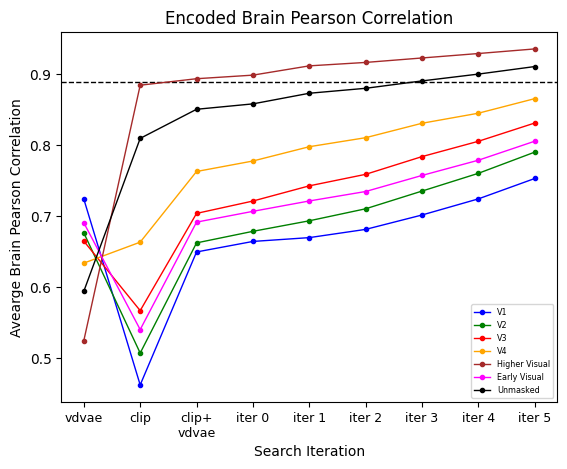

In [5]:
# Average Iteration Brain Region Plot

import matplotlib.pyplot as plt

brain_correlation_V1 = []
brain_correlation_V2 = []
brain_correlation_V3 = []
brain_correlation_V4 = []
brain_correlation_early_visual = []
brain_correlation_higher_visual = []
brain_correlation_unmasked = []
brain_correlation_ground_truth = []

folders = {"vdvae_distribution" : 2, "clip_distribution" : 1, "clip+vdvae_distribution" : 3, "iter_0" : 4, "iter_1" : 5 , "iter_2" : 6, "iter_3" : 7, "iter_4" : 8, "iter_5" : 9}
x = ["vdvae", "clip", "clip+\nvdvae", "iter 0", "iter 1", "iter 2", "iter 3", "iter 4", "iter 5"]

for folder, sample_indicator in folders.items():
    
    iteration_val_v1 = df.loc[(df['Sample Indicator'] == sample_indicator)]['Brain Correlation V1'].mean()
    iteration_val_v2 = df.loc[(df['Sample Indicator'] == sample_indicator)]['Brain Correlation V2'].mean()
    iteration_val_v3 = df.loc[(df['Sample Indicator'] == sample_indicator)]['Brain Correlation V3'].mean()
    iteration_val_v4 = df.loc[(df['Sample Indicator'] == sample_indicator)]['Brain Correlation V4'].mean()
    iteration_val_ev = df.loc[(df['Sample Indicator'] == sample_indicator)]['Brain Correlation Early Visual'].mean()
    iteration_val_hv = df.loc[(df['Sample Indicator'] == sample_indicator)]['Brain Correlation Higher Visual'].mean()
    iteration_val_unmasked = df.loc[(df['Sample Indicator'] == sample_indicator)]['Brain Correlation NSD General'].mean()
    
    brain_correlation_V1.append(iteration_val_v1)
    brain_correlation_V2.append(iteration_val_v2)
    brain_correlation_V3.append(iteration_val_v3)
    brain_correlation_V4.append(iteration_val_v4)
    brain_correlation_early_visual.append(iteration_val_ev)
    brain_correlation_higher_visual.append(iteration_val_hv)
    brain_correlation_unmasked.append(iteration_val_unmasked)
    

# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V1'].mean(), color = 'blue', linestyle = 'dashed', linewidth=1)
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V2'].mean(), color = 'green', linestyle = 'dashed', linewidth=1)
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V3'].mean(), color = 'red',linestyle = 'dashed', linewidth=1)
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V4'].mean(), color = 'orange',linestyle = 'dashed', linewidth=1)
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Higher Visual'].mean(), color = 'brown', linestyle = 'dashed', linewidth=1)
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Early Visual'].mean(),  color = 'magenta',linestyle = 'dashed', linewidth=1)
plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation NSD General'].mean(), color = 'black', linestyle = 'dashed', linewidth=1)

plt.plot(brain_correlation_V1, marker='.', color = 'blue', label = 'V1', linewidth=1)
plt.plot(brain_correlation_V2, marker='.', color = 'green',label = 'V2', linewidth=1)
plt.plot(brain_correlation_V3, marker='.', color = 'red',  label = 'V3', linewidth=1)
plt.plot(brain_correlation_V4, marker='.', color = 'orange', label = 'V4', linewidth=1)
plt.plot(brain_correlation_higher_visual, marker='.', color = 'brown', label = 'Higher Visual', linewidth=1)
plt.plot(brain_correlation_early_visual, marker='.',  color = 'magenta', label = 'Early Visual', linewidth=1)
plt.plot(brain_correlation_unmasked, marker='.',  color = 'black', label = 'NSD General', linewidth=1)
plt.xticks(range(len(x)), x,fontsize=9)

plt.legend(fontsize = "xx-small")
plt.xlabel("Search Iteration")
plt.ylabel("Avearge Brain Pearson Correlation")
plt.title("Encoded Brain Pearson Correlation")
mpl.rcParams['figure.dpi'] = 300


/tmp/ipykernel_25907/818572092.py:178: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[7].set_color('silver')


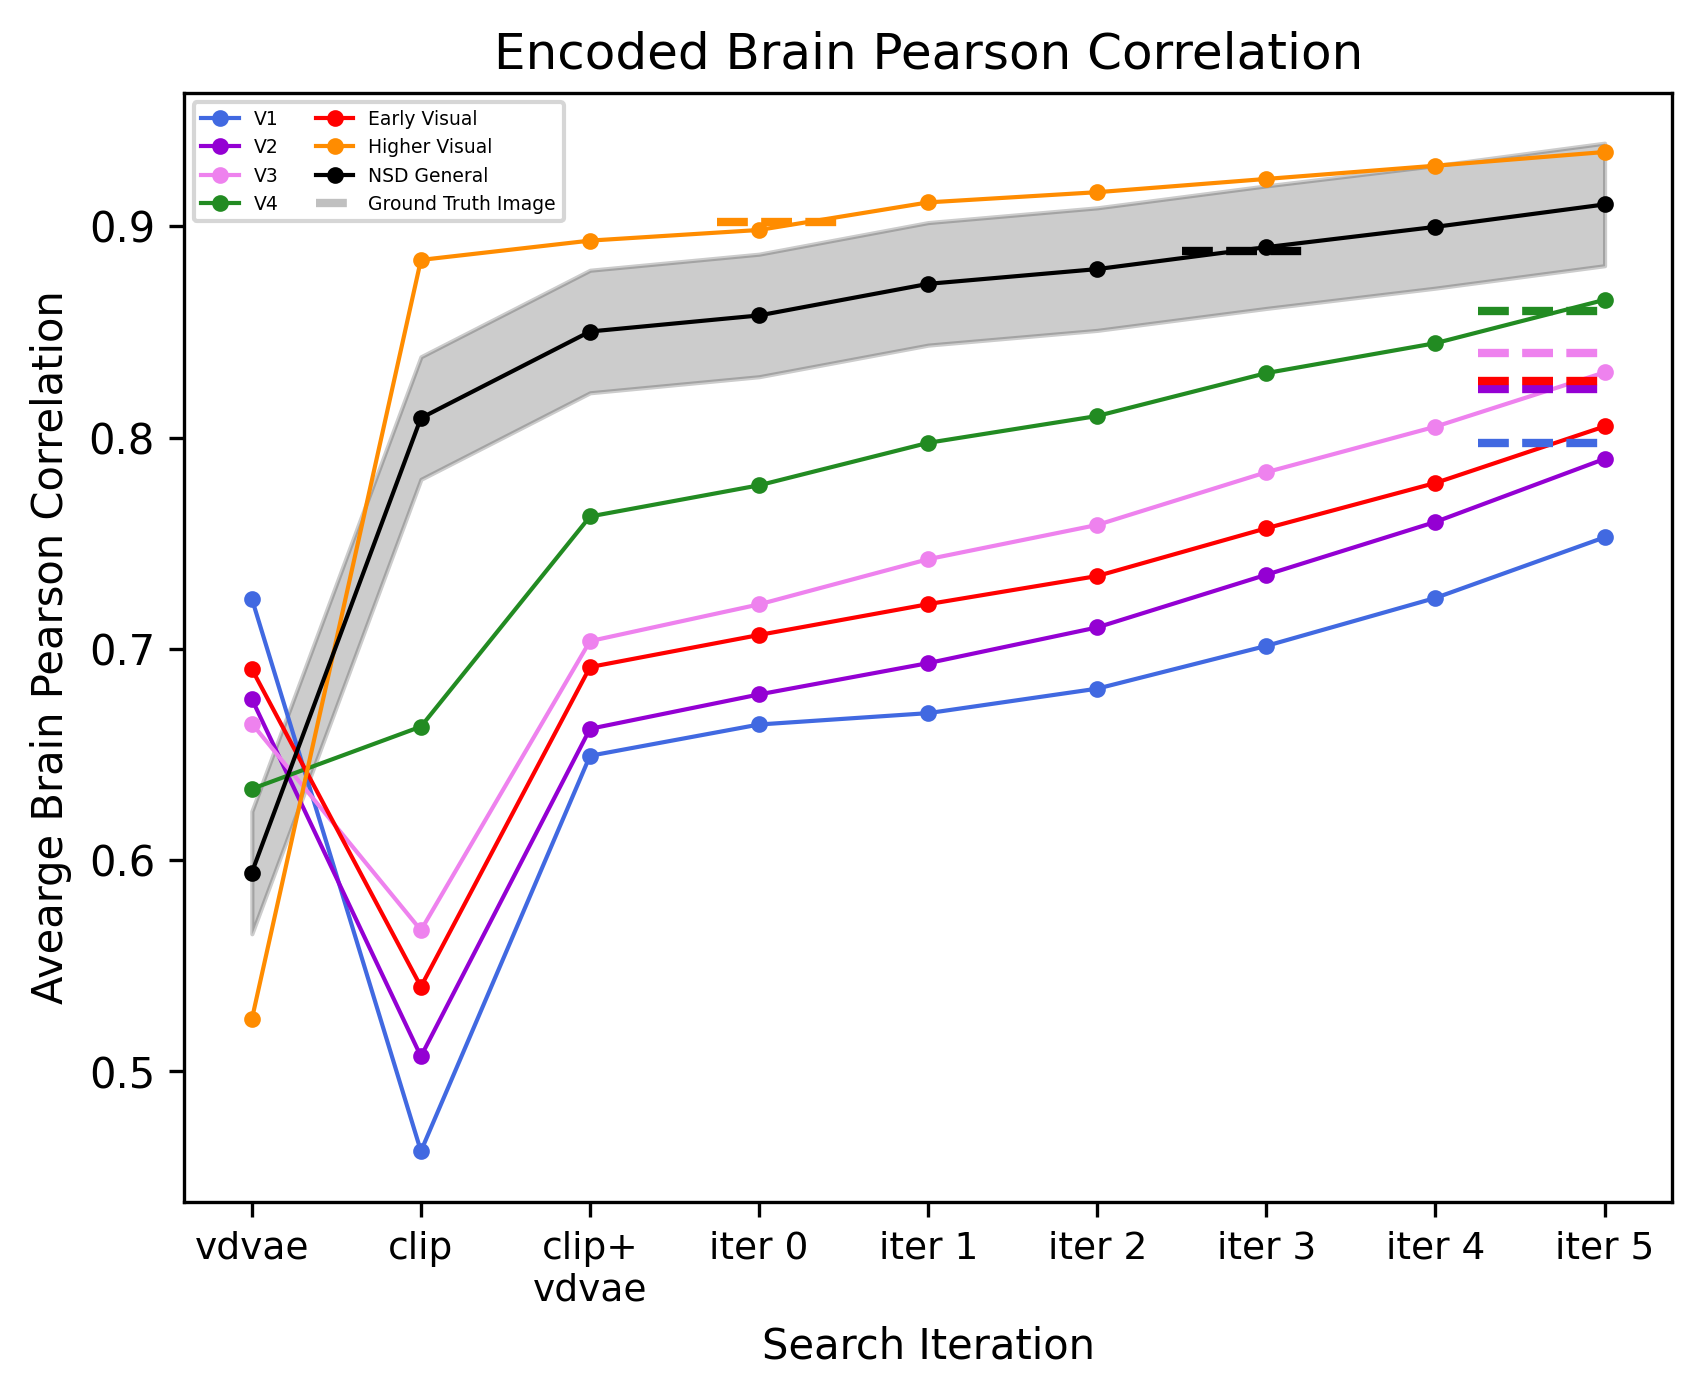

In [27]:
# Average Iteration Brain Region Plot

brain_correlation_V1 = []
brain_correlation_V2 = []
brain_correlation_V3 = []
brain_correlation_V4 = []
brain_correlation_early_visual = []
brain_correlation_higher_visual = []
brain_correlation_unmasked = []
brain_correlation_ground_truth = []

y_v1 = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V1'].mean()
y_v2 = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V2'].mean()
y_v3 = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V3'].mean()
y_v4 = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V4'].mean()
y_ev = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Early Visual'].mean()
y_hv = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Higher Visual'].mean()
y_unmasked = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation NSD General'].mean()

v1_set = True
v2_set = True
v3_set = True
v4_set = True
ev_set = True
hv_set = True
unmasked_set = True

x_v1 = 0 
x_v2 = 0 
x_v3 = 0 
x_v4 = 0 
x_ev = 0 
x_hv = 0 
x_umasked = 0 

folders = {"vdvae_distribution" : 2, "clip_distribution" : 1, "clip+vdvae_distribution" : 3, "iter_0" : 4, "iter_1" : 5 , "iter_2" : 6, "iter_3" : 7, "iter_4" : 8, "iter_5" : 9}
x = ["vdvae", "clip", "clip+\nvdvae", "iter 0", "iter 1", "iter 2", "iter 3", "iter 4", "iter 5"]
iteration = 0


for folder, sample_indicator in folders.items():
    
    iteration_val_v1 = df.loc[(df['Sample Indicator'] == sample_indicator)]['Brain Correlation V1'].mean()
    iteration_val_v2 = df.loc[(df['Sample Indicator'] == sample_indicator)]['Brain Correlation V2'].mean()
    iteration_val_v3 = df.loc[(df['Sample Indicator'] == sample_indicator)]['Brain Correlation V3'].mean()
    iteration_val_v4 = df.loc[(df['Sample Indicator'] == sample_indicator)]['Brain Correlation V4'].mean()
    iteration_val_ev = df.loc[(df['Sample Indicator'] == sample_indicator)]['Brain Correlation Early Visual'].mean()
    iteration_val_hv = df.loc[(df['Sample Indicator'] == sample_indicator)]['Brain Correlation Higher Visual'].mean()
    iteration_val_unmasked = df.loc[(df['Sample Indicator'] == sample_indicator)]['Brain Correlation NSD General'].mean()
    
    brain_correlation_V1.append(iteration_val_v1)
    brain_correlation_V2.append(iteration_val_v2)
    brain_correlation_V3.append(iteration_val_v3)
    brain_correlation_V4.append(iteration_val_v4)
    brain_correlation_early_visual.append(iteration_val_ev)
    brain_correlation_higher_visual.append(iteration_val_hv)
    brain_correlation_unmasked.append(iteration_val_unmasked)
    
    if(iteration_val_v1 > y_v1 and v1_set):
        x_v1 = iteration - 1
        v1_set = False
        
    if(iteration_val_v2 > y_v2 and v2_set):
        x_v2 = iteration - 1
        v2_set = False
        
    if(iteration_val_v3 > y_v3 and v3_set):
        x_v3 = iteration - 1
        v3_set = False
        
    if(iteration_val_v4 > y_v4 and v4_set):
        x_v4 = iteration - 1
        v4_set = False
        
    if(iteration_val_ev > y_ev and ev_set):
        x_ev = iteration - 1
        ev_set = False
        
    if(iteration_val_hv > y_hv and hv_set):
        x_hv = iteration - 1
        hv_set = False
        
    if(iteration_val_unmasked > y_unmasked and unmasked_set):
        x_unmasked = iteration - 1
        unmasked_set = False
        
    iteration += 1
    
# print(df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Unmasked'].mean())
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Unmasked'].mean(), linestyle = 'dashed', label = 'Brain Correlation Unmasked')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V1'].mean(), linestyle = '-', label = 'Brain Correlation V1')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V2'].mean(), linestyle = '-', label = 'Brain Correlation V2')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V3'].mean(), linestyle = '-', label = 'Brain Correlation V3')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V4'].mean(), linestyle = '-', label = 'Brain Correlation V4')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Higher Visual'].mean(), linestyle = '-', label = 'Brain Correlation Higher Visual')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Early Visual'].mean(), linestyle = '-', label = 'Brain Correlation Higher Visual')


N = 9
#x = np.array([0,1,2,3,4,5,6,7,8,9])
# y = np.array(brain_correlation_unmasked)
# a, b = np.polyfit(x, brain_correlation_unmasked, deg=1)
# y_est = a * x + b
# y_err = st.t.interval(alpha=0.95, df=len(y)-1, loc=np.mean(y), scale=st.sem(y))
# print(y_err[0])
# print(y_err[1])

y_un = np.array(brain_correlation_unmasked)
ci_un = 0.95 * np.std(y_un) / math.sqrt(N)

# y_hi = np.array(brain_correlation_higher_visual)
# ci_hi = 0.95 * np.std(y_hi) / math.sqrt(N)

# y_er = np.array(brain_correlation_early_visual)
# ci_er = 0.95 * np.std(y_er) / math.sqrt(N)

# y_vo = np.array(brain_correlation_V1)
# ci_vo = 0.95 * np.std(y_vo) / math.sqrt(N)

# y_vt = np.array(brain_correlation_V2)
# ci_vt = 0.95 * np.std(y_vt) / math.sqrt(N)

# y_vth = np.array(brain_correlation_V3)
# ci_vth = 0.95 * np.std(y_vth) / math.sqrt(N)

# y_vf = np.array(brain_correlation_V4)
# ci_vf = 0.95 * np.std(y_vf) / math.sqrt(N)

# def mean_confidence_interval(data, confidence=0.95):
#     a = 1.0 * np.array(data)
#     n = len(a)
#     m, se = np.mean(a), scipy.stats.sem(a)
#     h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
#     return m, m-h, m+h

# mean, lower, upper = [],[],[]
# ci = 0.95

# m, ml, mu = mean_confidence_interval(y, ci)
# mean.append(m)
# lower.append(ml)
# upper.append(mu)


plt.plot(brain_correlation_V1, marker='.', label = 'V1', linewidth=1, color = "royalblue")
plt.plot(brain_correlation_V2, marker='.', label = 'V2', linewidth=1, color = "darkviolet")
plt.plot(brain_correlation_V3, marker='.', label = 'V3', linewidth=1, color = "violet")
plt.plot(brain_correlation_V4, marker='.', label = 'V4', linewidth=1, color = "forestgreen")
plt.plot(brain_correlation_early_visual, marker='.', label = 'Early Visual', linewidth=1, color = "red")
plt.plot(brain_correlation_higher_visual, marker='.', label = 'Higher Visual', linewidth=1, color = "darkorange")
plt.plot(brain_correlation_unmasked, marker='.', label = 'NSD General', linewidth=1, color = "black")
plt.xticks(range(len(x)), x,fontsize=9)
# plt.fill_between(x, y_err[0], y_err[0], color='dimgray', alpha=0.2)
# plt.fill_between(x, upper, lower, color='dimgray', alpha=0.2)
plt.fill_between(x, (y_un-ci_un), (y_un+ci_un), color='black', alpha=.2)
# plt.fill_between(x, (y_hi-ci_hi), (y_hi+ci_hi), color='darkorange', alpha=.2)
# plt.fill_between(x, (y_er-ci_er), (y_er+ci_er), color='red', alpha=.2)
# plt.fill_between(x, (y_vo-ci_vo), (y_vo+ci_vo), color='royalblue', alpha=.2)
# plt.fill_between(x, (y_vt-ci_vt), (y_vt+ci_vt), color='darkviolet', alpha=.2)
# plt.fill_between(x, (y_vth-ci_vth), (y_vth+ci_vth), color='violet', alpha=.2)
# plt.fill_between(x, (y_vf-ci_vf), (y_vf+ci_vf), color='forestgreen', alpha=.2)

plt.plot([7.25, 7 + 1], [y_v1, y_v1] , color = "royalblue", linestyle="dashed", linewidth=2)
plt.plot([7.25, 7 + 1], [y_v2, y_v2] , color = "darkviolet", linestyle="dashed", linewidth=2)
plt.plot([7.25, 7 + 1], [y_v3, y_v3] , color = "violet", linestyle="dashed", linewidth=2)
plt.plot([x_v4 + 0.25, x_v4 + 1], [y_v4, y_v4] , color = 'forestgreen', linestyle="dashed", linewidth=2)
plt.plot([7.25, 7 + 1], [y_ev - 0.002, y_ev - 0.002] , color = 'red', linestyle="dashed", linewidth=2)
plt.plot([x_hv - 0.25, x_hv + 0.50], [y_hv, y_hv] , color = "darkorange", linestyle="dashed", linewidth=2)
plt.plot([x_unmasked + 0.5, x_unmasked + 1.25], [y_unmasked, y_unmasked] , color = 'black', linestyle="dashed", linewidth=2, label="Ground Truth Image")
#plt.axhline(x = [1,3], y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Unmasked'].mean(), linestyle = 'dashed', label = 'Brain Correlation Unmasked')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V1'].mean(), linestyle = '-', label = 'Brain Correlation V1')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V2'].mean(), linestyle = '-', label = 'Brain Correlation V2')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V3'].mean(), linestyle = '-', label = 'Brain Correlation V3')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V4'].mean(), linestyle = '-', label = 'Brain Correlation V4')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Higher Visual'].mean(), linestyle = '-', label = 'Brain Correlation Higher Visual')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Early Visual'].mean(), linestyle = '-', label = 'Brain Correlation Higher Visual')
leg = plt.legend(loc="upper left", ncol = 2, fontsize = "4.5")
leg.legendHandles[7].set_color('silver')
plt.xlabel("Search Iteration")
plt.ylabel("Avearge Brain Pearson Correlation")
plt.title("Encoded Brain Pearson Correlation")
mpl.rcParams['figure.dpi'] = 300


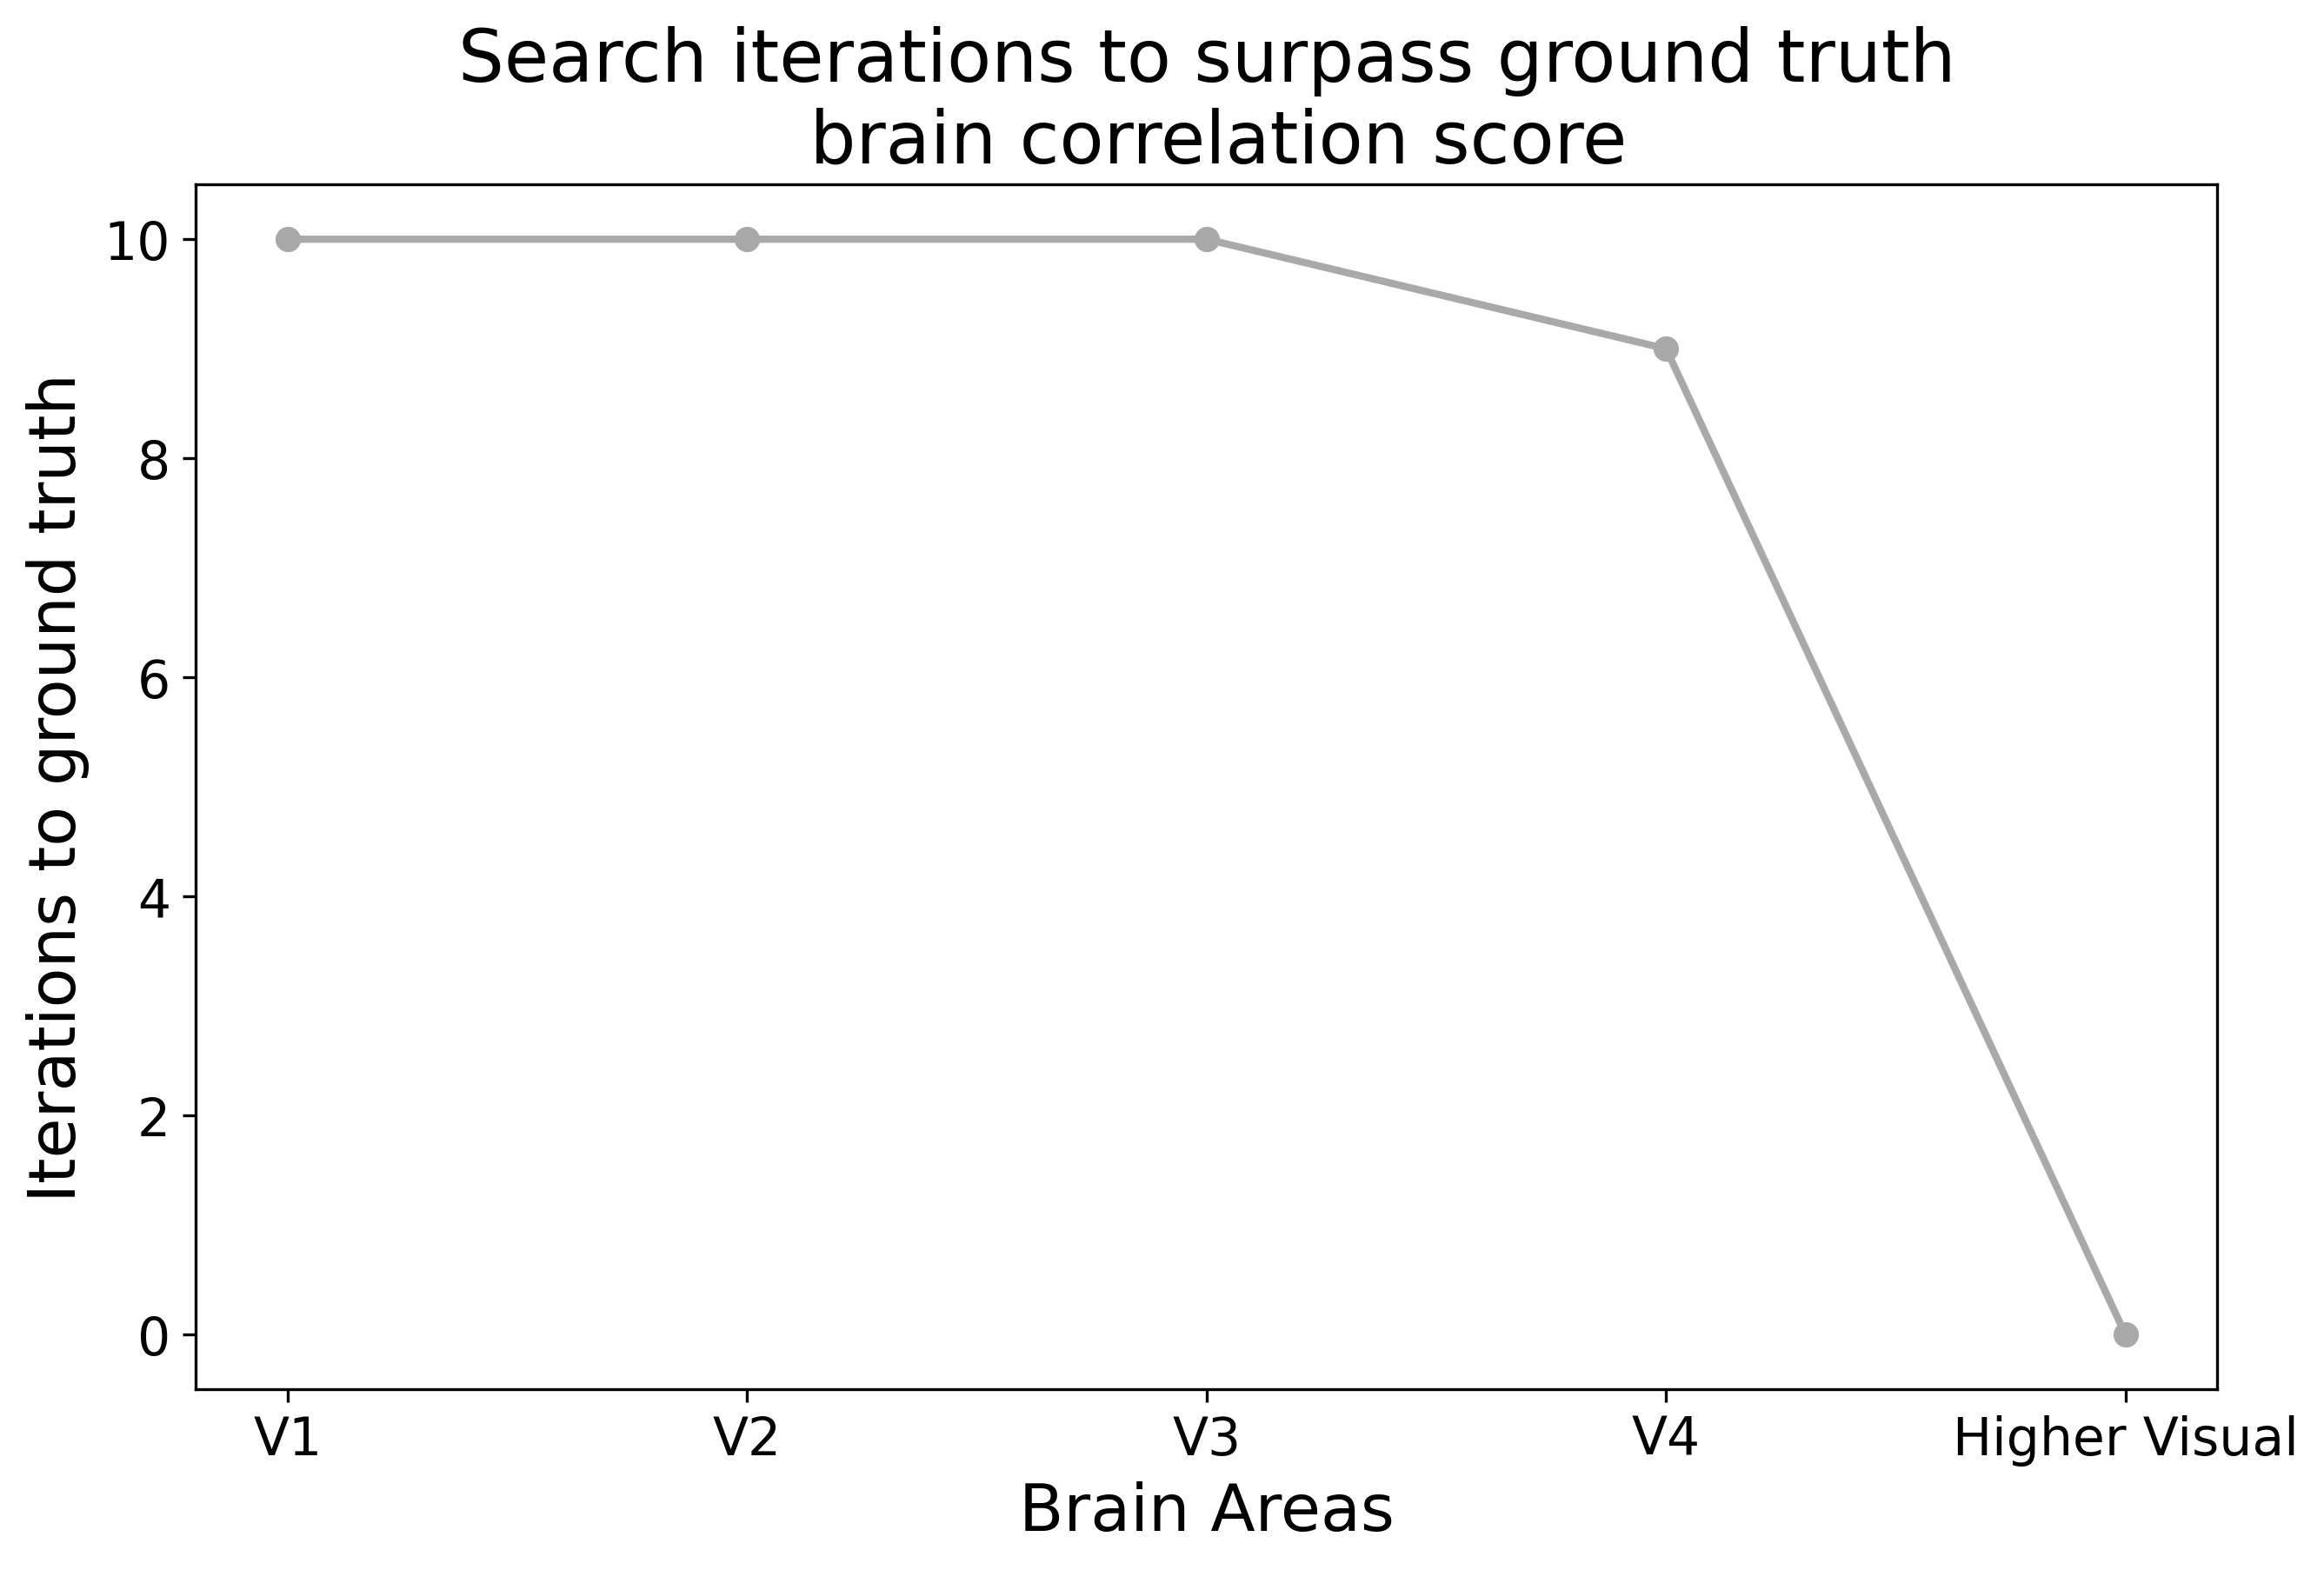

In [31]:
# Search iterations to Ground Truth

x_iter_values = []

x_iter_values.append(10)
x_iter_values.append(10)
x_iter_values.append(10)
x_iter_values.append(9)
x_iter_values.append(0)

x_labels = ['V1', 'V2', 'V3', 'V4', 'Higher Visual']

# x_iter_values.append(0)
# x_iter_values.append(x_v4)
# x_iter_values.append(x_v3)
# x_iter_values.append(x_v2)
# x_iter_values.append(9)

# x_labels = ['Higher Visual', 'V4', 'V3', 'V2', 'V1']

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(x_labels, x_iter_values, marker='o', linewidth=2, color = "darkgray")

plt.xlabel("Brain Areas", fontsize=18)
plt.ylabel("Iterations to ground truth", fontsize=18)
plt.title("Search iterations to surpass ground truth\n brain correlation score", fontsize=20)
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['ytick.labelsize'] = 'x-large'

In [ ]:
# Single Iteration Brain Region Plot

sample_0 = []
sample_1 = []
sample_2 = []
sample_3 = []
sample_4 = []
sample_5 = []
sample_6 = []
sample_7 = []
sample_8 = []
sample_9 = []

for iteration in range(10):
    sample_0.append(df.loc[(df['Iter'] == iteration) & (df['ID'] == 0)]['Brain Correlation Unmasked'])
    sample_1.append(df.loc[(df['Iter'] == iteration) & (df['ID'] == 1)]['Brain Correlation Unmasked'])
    sample_2.append(df.loc[(df['Iter'] == iteration) & (df['ID'] == 2)]['Brain Correlation Unmasked'])
    sample_3.append(df.loc[(df['Iter'] == iteration) & (df['ID'] == 3)]['Brain Correlation Unmasked'])
    sample_4.append(df.loc[(df['Iter'] == iteration) & (df['ID'] == 4)]['Brain Correlation Unmasked'])
    sample_5.append(df.loc[(df['Iter'] == iteration) & (df['ID'] == 5)]['Brain Correlation Unmasked'])
    sample_6.append(df.loc[(df['Iter'] == iteration) & (df['ID'] == 6)]['Brain Correlation Unmasked'])
    sample_7.append(df.loc[(df['Iter'] == iteration) & (df['ID'] == 7)]['Brain Correlation Unmasked'])
    sample_8.append(df.loc[(df['Iter'] == iteration) & (df['ID'] == 8)]['Brain Correlation Unmasked'])
    sample_9.append(df.loc[(df['Iter'] == iteration) & (df['ID'] == 9)]['Brain Correlation Unmasked'])


plt.plot(sample_0, label = 'Sample 0')
plt.plot(sample_1, label = 'Sample 1')
plt.plot(sample_2, label = 'Sample 2')
plt.plot(sample_3, label = 'Sample 3')
plt.plot(sample_4, label = 'Sample 4')
plt.plot(sample_5, label = 'Sample 5')
plt.plot(sample_6, label = 'Sample 6')
plt.plot(sample_7, label = 'Sample 7')
plt.plot(sample_8, label = 'Sample 8')
plt.plot(sample_9, label = 'Sample 9')
plt.legend(fontsize = "x-small")
plt.xlabel("Search Iteration")
plt.ylabel("Brain Pearson Correlation")
plt.title("Encoded Brain Pearson Correlation Unmasked")

/export/raid1/home/ojeda040/Second-Sight
0


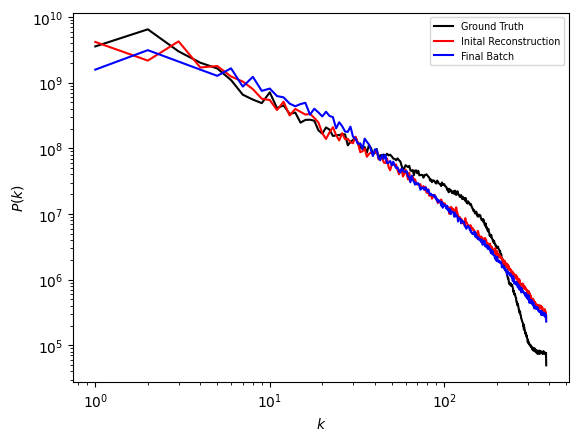

In [12]:
# Fourier Transform of Images
import matplotlib.pyplot as plt
import torch.nn as nn
from skimage import io
print(os.getcwd())

os.chdir("/export/raid1/home/ojeda040/Second-Sight")

subject = 5
folder = "Final Run: SCS UC LD 6:100:4 Dual Guided clip_iter"
image = "Ground Truth"

best_batch = torch.load("/home/naxos2-raid25/ojeda040/local/ojeda040/Second-Sight/reconstructions/subject" + str(subject) + "/" + folder + "/0/iter_5/best_batch_index.pt")
print(int(best_batch))

path_clip_distribution   = "/home/naxos2-raid25/ojeda040/local/ojeda040/Second-Sight/reconstructions/subject" + str(subject) + "/" + folder + "/0/clip_distribution/"
path_iter_batch          = "/home/naxos2-raid25/ojeda040/local/ojeda040/Second-Sight/reconstructions/subject" + str(subject) + "/" + folder + "/0/iter_5/batch_" + str(int(best_batch)) +"/"
path                     = "/home/naxos2-raid25/ojeda040/local/ojeda040/Second-Sight/reconstructions/subject" + str(subject) + "/" + folder + "/0/"
path_grayscale           = "/home/naxos2-raid25/ojeda040/local/ojeda040/Second-Sight/reconstructions/subject" + str(subject) + "/" + folder + "/" + "0/" + image + "Grayscale.png"

def convert_images_grayscale(path, filename): 
    
    # Set paths
    path_filename   = path + filename
    path_grayscale  = path_filename + " Grayscale.png"
    
    # Convert the image to grayscale
    img_rgb = Image.open(path_filename + ".png")
    img_gray = img_rgb.convert('L')
    img_gray.save(path_grayscale)

def create_power_spectrum(path):

    # Create a numpy array of the image.
    image = mpimg.imread(path)

    npix = image.shape[0]

    # Fourier transform of two dimensional image data array
    fourier_image = np.fft.fftn(image)

    # The Fourier image array now contains the complex valued amplitudes of all the Fourier components. 
    # Only require the square of the amplitudes to compute the variances.
    fourier_amplitudes = np.abs(fourier_image)**2

    # Automatically return a one dimensional array containing the wave vectors for the numpy.fft.fftn call, in the correct order.
    kfreq = np.fft.fftfreq(npix) * npix

    # Convert this to a two dimensional array matching the layout of the two dimensional Fourier image
    kfreq2D = np.meshgrid(kfreq, kfreq)

    # Interested in the actual wave vectors, but rather in their norm
    knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)

    # No longer need the wave vector norms or Fourier image to be laid out as a two dimensional array, so we will flatten them
    knrm = knrm.flatten()
    fourier_amplitudes = fourier_amplitudes.flatten()

    # To bin the amplitudes in k space, we need to set up wave number bins.
    kbins = np.arange(0.5, npix//2+1, 1.)

    # The kbin array will contain the start and end points of all bins; the corresponding  k values are the midpoints of these bins
    kvals = 0.5 * (kbins[1:] + kbins[:-1])

    # To compute the average Fourier amplitude (squared) in each bin
    Abins, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                        statistic = "mean",
                                        bins = kbins)

    # Remember that we want the total variance within each bin. Right now, we only have the average power.
    # To get the total power, we need to multiply with the volume in each bin (in 2D, this volume is actually a surface area)
    Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)
    
    # kvals = Frequency
    # Abins = Amplitude 
    return kvals, Abins

# -------------------------------------
# Steps:
    # Z-score all the images
    # COnvert the image into a 2D fft
    #


# -------------------------------------


# Ground Truth Line
#convert_images_grayscale(path, "Ground Truth")
kvals_ground_truth, Abins_ground_truth = create_power_spectrum(path + "Ground Truth Grayscale.png")

kvals_clip_distribution = []
Abins_clip_distribution = []
for i in range(10):
    
    #convert_images_grayscale(path_clip_distribution, str(i))
    kval, Abin = create_power_spectrum(path_clip_distribution + str(i) + " Grayscale.png")
    kvals_clip_distribution.append(kval)
    Abins_clip_distribution.append(Abin)
    
kvals_iter_batch = []
Abins_iter_batch = []
for i in range(10):
    
    #convert_images_grayscale(path_iter_batch, str(i))
    kval, Abin = create_power_spectrum(path_iter_batch + str(i) + " Grayscale.png")
    kvals_iter_batch.append(kval)
    Abins_iter_batch.append(Abin)
    

plt.loglog(kvals_ground_truth, Abins_ground_truth, color = "black", label = "Ground Truth")
plt.loglog(kvals_clip_distribution[0], Abins_clip_distribution[0], color = "red", label = "Inital Reconstruction")
# plt.loglog(kvals_clip_distribution[1], Abins_clip_distribution[1])
plt.loglog(kvals_iter_batch[0], Abins_iter_batch[0], color = "blue", label = "Final Batch")
# plt.loglog(kvals_iter_batch[1], Abins_iter_batch[1])
plt.xlabel("$k$")
plt.ylabel("$P(k)$")
plt.legend(fontsize = "x-small")
plt.show()




In [42]:
['ID', 'Sample Count', 'Batch Number', 'Search Reconstruction', 'Sample Indicator', 'Strength', 'Brain Correlation V1', 'Brain Correlation V2', 
'Brain Correlation V3', 'Brain Correlation V4', 'Brain Correlation Early Visual', 'Brain Correlation Higher Visual', 'Brain Correlation NSD General',
'SSIM', 'Pixel Correlation', 'CLIP Cosine', 'CLIP Two-way', 'AlexNet 2', 'AlexNet 5', 'AlexNet 7', 'Inception V3', 'EffNet-B', 'SwAV']

folders = {2 : "vdvae_distribution", 1 : "clip_distribution", 3 : "clip+vdvae_distribution", 4 : "iter_0", 5 : "iter_1", 6 : "iter_2", 7 : "iter_3", 8 : "iter_4", 9 : "iter_5"}
ID = 730

single_sample = df.loc[(df['ID'] == ID)]
single_sample = single_sample[['ID', 'Sample Count', 'Batch Number', 'Search Reconstruction', 'Sample Indicator', 'Brain Correlation V1', 'Brain Correlation V2', 
'Brain Correlation V3', 'Brain Correlation V4', 'Brain Correlation Early Visual', 'Brain Correlation Higher Visual', 'Brain Correlation NSD General']]

ground_truth_v1 = float(single_sample.loc[(df['Sample Indicator'] == 0)]['Brain Correlation V1'])
ground_truth_v2 = float(single_sample.loc[(df['Sample Indicator'] == 0)]['Brain Correlation V2'])
ground_truth_v3 = float(single_sample.loc[(df['Sample Indicator'] == 0)]['Brain Correlation V3'])
ground_truth_v4 = float(single_sample.loc[(df['Sample Indicator'] == 0)]['Brain Correlation V4'])
ground_truth_ev = float(single_sample.loc[(df['Sample Indicator'] == 0)]['Brain Correlation Early Visual'])
ground_truth_hv = float(single_sample.loc[(df['Sample Indicator'] == 0)]['Brain Correlation Higher Visual'])
ground_truth_nsd = float(single_sample.loc[(df['Sample Indicator'] == 0)]['Brain Correlation NSD General'])

v1_found = False
v2_found = False
v3_found = False
v4_found = False
ev_found = False
hv_found = False
nsd_found = False

single_sample = single_sample[:-1]

print("ID: ", ID)
for index, row in single_sample.iterrows():
    v1 = row['Brain Correlation V1']
    v2 = row['Brain Correlation V2']
    v3 = row['Brain Correlation V3']
    v4 = row['Brain Correlation V4']
    ev = row['Brain Correlation Early Visual']
    hv = row['Brain Correlation Higher Visual']
    nsd = row['Brain Correlation NSD General']
    
    sample = row['Sample Indicator']
    batch = row['Batch Number']
    
    if(v1 > ground_truth_v1 and v1_found == False):
        print("--------V1---------")
        print("Batch Nnumber: ", batch)
        print("Sample: ", folders[sample])
        v1_found = True
        
    if(v2 > ground_truth_v2 and v2_found == False):
        print("--------V2---------")
        print("Batch Nnumber: ", batch)
        print("Sample: ", folders[sample])
        v2_found = True
        
    if(v3 > ground_truth_v3 and v3_found == False):
        print("--------V3---------")
        print("Batch Nnumber: ", batch)
        print("Sample: ",  folders[sample])
        v3_found = True
        
    if(v4 > ground_truth_v4 and v4_found == False):
        print("--------V4---------")
        print("Batch Nnumber: ", batch)
        print("Sample: ",  folders[sample])
        v4_found = True
          
    if(ev > ground_truth_ev and ev_found == False):
        print("--------EV---------")
        print("Batch Nnumber: ", batch)
        print("Sample: ",  folders[sample])
        ev_found = True
        
    if(hv > ground_truth_hv and hv_found == False):
        print("--------HV---------")
        print("Batch Nnumber: ", batch)
        print("Sample: ",  folders[sample])
        hv_found = True
        
    if(nsd > ground_truth_nsd and nsd_found == False):
        print("--------NSD---------")
        print("Batch Nnumber: ", batch)
        print("Sample: ",  folders[sample])
        nsd_found = True
        
    
    
single_sample.head(47)

ID:  730
--------HV---------
Batch Nnumber:  nan
Sample:  clip_distribution
--------V1---------
Batch Nnumber:  nan
Sample:  vdvae_distribution
--------NSD---------
Batch Nnumber:  1.0
Sample:  iter_3


/tmp/ipykernel_128841/2660064201.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ground_truth_v1 = float(single_sample.loc[(df['Sample Indicator'] == 0)]['Brain Correlation V1'])
/tmp/ipykernel_128841/2660064201.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ground_truth_v2 = float(single_sample.loc[(df['Sample Indicator'] == 0)]['Brain Correlation V2'])
/tmp/ipykernel_128841/2660064201.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ground_truth_v3 = float(single_sample.loc[(df['Sample Indicator'] == 0)]['Brain Correlation V3'])
/tmp/ipykernel_128841/2660064201.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future.

,ID,Sample Count,Batch Number,Search Reconstruction,Sample Indicator,Brain Correlation V1,Brain Correlation V2,Brain Correlation V3,Brain Correlation V4,Brain Correlation Early Visual,Brain Correlation Higher Visual,Brain Correlation NSD General
31114,730,0.0,NaN,NaN,1,0.610565,0.612364,0.706003,0.910608,0.654023,0.913608,0.857799
31115,730,1.0,NaN,NaN,1,0.476342,0.558407,0.688507,0.870235,0.622558,0.933449,0.885868
31116,730,2.0,NaN,NaN,1,-0.373144,-0.205977,0.042157,0.473242,-0.080883,0.911076,0.708848
31117,730,3.0,NaN,NaN,1,0.486211,0.540377,0.680968,0.881073,0.603613,0.907645,0.851431
31118,730,4.0,NaN,NaN,1,0.270859,0.298480,0.370783,0.791514,0.387641,0.945289,0.854217
31119,730,0.0,NaN,NaN,2,0.789155,0.765070,0.801951,0.845912,0.795738,0.838573,0.826790
31120,730,1.0,NaN,NaN,2,0.799251,0.801562,0.815685,0.812341,0.796289,0.806956,0.802130
31121,730,2.0,NaN,NaN,2,0.797533,0.773971,0.800956,0.789289,0.775835,0.792290,0.789799
31122,730,3.0,NaN,NaN,2,0.798481,0.780931,0.794528,0.773855,0.771098,0.761158,0.761241
31123,730,4.0,NaN,NaN,2,0.841851,0.833675,0.841504,0.852693,0.833171,0.863602,0.854591
